In [22]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from prettytable import PrettyTable

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from scipy import *
from scipy.sparse import *

In [23]:
path = 'Reviews.csv'
df = pd.read_csv(path)
data = df

In [24]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [25]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## We are getting started by cleaning the data frame by dropping any rows that have missing values.

### 1.) The score column is scaled from 1 to 5 so we will remove all scores equal to 3 because we assume these are neutral and doesn't provide us any information

### 2.) We decide to add a new column "Positivity" where any score of above 3 is encoded as a 1 indicating it has been positively rated otherwise it would be encoded as 0 indicating it is negatively rated.

In [37]:
df.dropna(inplace=True)
df[df['Score'] != 3]
df['Positivity'] = np.where(df['Score'] > 3, 1, 0)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Positivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


### Now, let’s split our data into random training and test subsets using “Text” and “Positivity” columns, and then print out the first entry and the shape of the training set.

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Positivity'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


X_train shape:  (426308,)


#### We used the CountVectorizer to fit the training data so that it gets converted into a matrix of token counts instead of text documents

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### The default configuration tokenizes the string, by extracting words of atleast 2 letters or numbers, seperated by word boundaries. After which it converts to lowercase and builds a vocabulary using these tokens.

#### We are using the method get_feature_names, inorder to get a sense of what the data set is all about.

In [40]:
vect.get_feature_names()[::2000]

['00',
 '255g',
 '843mg',
 'aftertraste',
 'anticarcinogens',
 'average',
 'b000mrd5jo',
 'b001rqemwi',
 'b005jd60wk',
 'beleive',
 'boobs',
 'buttersworth',
 'cc',
 'chuy',
 'compresses',
 'cramper',
 'decap',
 'difficulkt',
 'dreamy',
 'enchanted',
 'expedited',
 'fists',
 'frother',
 'gloved',
 'gurantees',
 'hiking_',
 'images',
 'intruder',
 'kavanagh',
 'lawry',
 'lowry',
 'matured',
 'misnomer',
 'mythreads',
 'numorous',
 'osco',
 'paupua',
 'pittston',
 'preshave',
 'quart',
 'refrigerante',
 'ringworm',
 'savedge',
 'sheer',
 'smiths',
 'sprklng',
 'subtotal',
 'taos',
 'tiis',
 'tubed',
 'unsuccessful',
 'vomitar',
 'wintery',
 'zest']

### Now we are trying to get the length inorder to know the exact number of features we are going to work with.

In [41]:
len(vect.get_feature_names())

106260

### Now, we transform the documents in X_train to a document term matrix, which gives us how often a word count happens for X_train. The result is stored in a SciPy sparse matrix, where each row corresponds to a document, and each column is a word from our training vocabulary.

In [42]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<426308x106260 sparse matrix of type '<class 'numpy.int64'>'
	with 22990341 stored elements in Compressed Sparse Row format>

### Now we will train the Logistic regression classifier based on matrix X_train_vectorized, as it works well for high dimensional sparse data

In [43]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Next, we’ll make predictions using X_test, and compute the area under the curve score.

In [44]:
from sklearn.metrics import roc_auc_score
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8431829561671762


### Sorting the ten smallest and ten largest coefficients, we can see the model has predicted words like “downhill”, “disappointing” and “tasteless” to negative reviews, and words like “quickness”, “tribute”, and “redeeming” to positive reviews.

In [45]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['downhill' 'quickness' 'dissapointing' 'realllly' 'bbb' 'tastless'
 'weiner' 'redeeming' 'limpest' 'deceptive']

Largest Coefs: 
['chedder' 'bertie' 'emeraldforest' 'blowout' 'antelop' 'hahaha' 'hears'
 'yielded' 'botch' 'tribute']



## However, our model can be improved as follow.

In [49]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from prettytable import PrettyTable

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from scipy import *
from scipy.sparse import *

In [50]:
final_data = data_s.drop_duplicates(subset=('UserId','ProfileName','Time','Text'))
final = final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]

In [51]:
final = final.sort_values(['Time'], axis=0)   #TIme based sorting
final = final.head(100000)

In [62]:
final_X = final['Text']
final_y = final['Score']

In [63]:
X_train = final_X[:75000]
X_test = final_X[75000:]
y_train = final_y[:75000]
y_test = final_y[75000:]

### Logistic Regression on BoW

In [64]:
count_vect = CountVectorizer(max_features = 2000, dtype='float')
bow_X_train = count_vect.fit_transform(X_train)
bow_X_test = count_vect.transform(X_test)

#### GridSearchCV

In [65]:
lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 1}
Accuracy on train data =  92.772


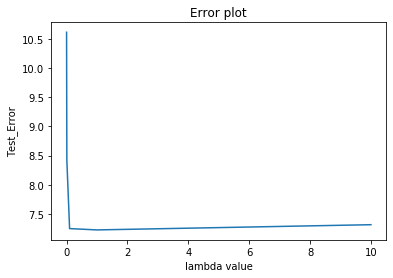

In [67]:
import matplotlib.pyplot as plt 

error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [68]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=92.216000%

precision=94.033199%

recall=97.144976%

F1-Score=95.563762%


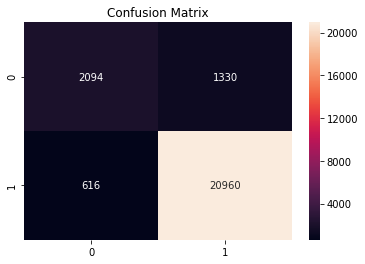

In [69]:
import seaborn as sns
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

##### Using L1 Regularizer

In [71]:
clf = LogisticRegression(C = optimal_a1 , penalty='l1')

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=92.164000%

precision=93.954739%

recall=97.172785%

F1-Score=95.536670%


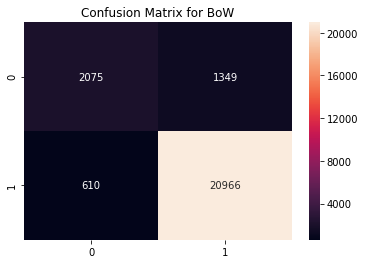

In [72]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

In [73]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 1 |    92.22    |      7.78     |    94.03     |   97.14   |    95.56    |
| Grid |      L1     | 1 |    92.16    |      7.84     |    93.95     |   97.17   |    95.54    |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+


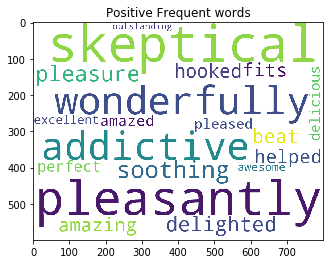

In [74]:
positive_log = np.array(list(map(abs,clf.coef_))).argsort()[0][1970:2000]

pos={}

for index in positive_log:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            pos[i]=clf.coef_[0][index]
            

from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 600,
background_color ='white').generate_from_frequencies(pos)
plt.imshow(wordcloud)
plt.title("Positive Frequent words")
plt.show()

### RandomizedSearchCV

In [75]:
from scipy.stats import uniform
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.31447548821024596}
Accuracy on train data =  92.85600000000001


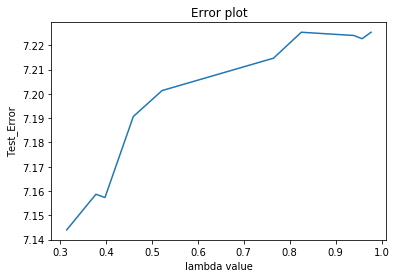

In [76]:
lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

##### Using L2 Regularizer (By default its L2)

In [78]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=92.140000%

precision=93.839138%

recall=97.279385%

F1-Score=95.528298%


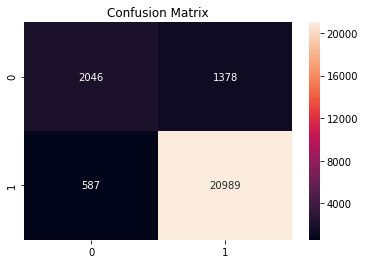

In [79]:

cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

#### Using L1 Regularizer

In [80]:
clf = LogisticRegression(C = optimal_a1 , penalty='l1')

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=92.064000%

precision=93.603668%

recall=97.464776%

F1-Score=95.495209%


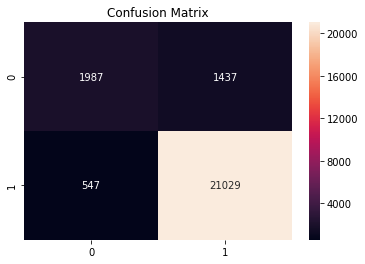

In [81]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [82]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Random'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)


acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+--------+-------------+---------------------+-------------+---------------+--------------+-----------+-------------+
|   CV   | Regularizer |          C          | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------+-------------+---------------------+-------------+---------------+--------------+-----------+-------------+
| Random |      L2     | 0.31447548821024596 |    92.14    |      7.86     |    93.84     |   97.28   |    95.53    |
| Random |      L1     | 0.31447548821024596 |    92.06    |      7.94     |     93.6     |   97.46   |     95.5    |
+--------+-------------+---------------------+-------------+---------------+--------------+-----------+-------------+


## Perturbation Test

#### Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New weights to find of collinearity.

In [83]:
# to calculate percentage change for both weights

def Weight_change(Pre_weights,New_weights):
    ch = 0
    for i in range(Pre_weights.shape[0]):
        if Pre_weights[i] != New_weights[i]:
            ch += 1
    
    per = (ch / Pre_weights.shape[0])*100
    
    return per
        

# Calculating previous weights

pre_w = clf.coef_[0]

noise_data = bow_X_train.todense()
noise_data[1323] += 0.01

clf = LogisticRegression(C = optimal_a1 , penalty='l1')
clf.fit(noise_data,y_train)

new_w = clf.coef_[0]

per_Change = Weight_change(pre_w,new_w)

print(per_Change)

76.05


##### Weights differ so much we can say features are collinear

##### Increasing lambda value to see error reports and sparsity check on L1 regularizer. As C Decreases Lambda value Increases

In [84]:
clf = LogisticRegression(C=100, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=10, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac2 = accuracy_score(y_test, pred) * 100
er2 = np.around(100 - ac2, decimals = 2)

w = clf.coef_
s2 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=1, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac3 = accuracy_score(y_test, pred) * 100
er3 = np.around(100 - ac3, decimals = 2)

w = clf.coef_
s3 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac4 = accuracy_score(y_test, pred) * 100
er4 = np.around(100 - ac4, decimals = 2)

w = clf.coef_
s4 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac5 = accuracy_score(y_test, pred) * 100
er5 = np.around(100 - ac5, decimals = 2)

w = clf.coef_
s5 = np.count_nonzero(w)

#======================================================================

##### Sparsity is Number of Non-Zero elements in weight vector

In [85]:
x = PrettyTable()

c = [100,10,1,0.1,0.01]

x.field_names = ['C','Train_Error(%)','Sparsity']

x.add_row([c[0],er1,s1])
x.add_row([c[1],er2,s2])
x.add_row([c[2],er3,s3])
x.add_row([c[3],er4,s4])
x.add_row([c[4],er5,s5])

print(x)

+------+----------------+----------+
|  C   | Train_Error(%) | Sparsity |
+------+----------------+----------+
| 100  |      7.94      |   1998   |
|  10  |      7.9       |   1981   |
|  1   |      7.84      |   1815   |
| 0.1  |      8.28      |   875    |
| 0.01 |     11.52      |   153    |
+------+----------------+----------+


### Logistic Regression on Tf-Idf

In [86]:
tf_idf = TfidfVectorizer(max_features=2000)
tf_X_train = tf_idf.fit_transform(X_train)
tf_X_test = tf_idf.transform(X_test)

#### GridSearchCV

In [88]:
lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(tf_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 10}
Accuracy on train data =  93.15733333333334


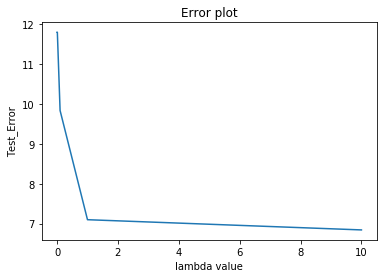

In [89]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [90]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=92.356000%

precision=94.185054%

recall=97.140341%

F1-Score=95.639873%


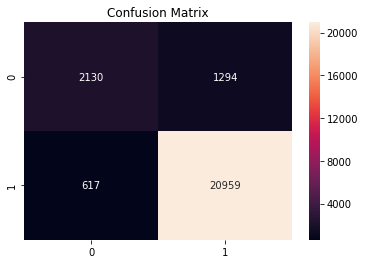

In [91]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

#### Using L1 Regularizer

In [93]:
clf = LogisticRegression(C = optimal_a1 , penalty='l1')

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=92.340000%

precision=94.351455%

recall=96.927141%

F1-Score=95.621957%


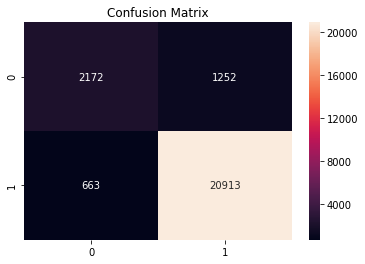

In [94]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [95]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 10 |    92.36    |      7.64     |    94.19     |   97.14   |    95.64    |
| Grid |      L1     | 10 |    92.34    |      7.66     |    94.35     |   96.93   |    95.62    |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+


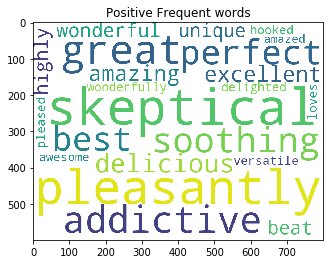

In [96]:
positive_log = np.array(list(map(abs,clf.coef_))).argsort()[0][1970:2000]

pos={}

for index in positive_log:
    for i in tf_idf.vocabulary_:
        if tf_idf.vocabulary_[i] == index:
            pos[i]=clf.coef_[0][index]
            

from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 600,background_color ='white').generate_from_frequencies(pos)
plt.imshow(wordcloud)
plt.title("Positive Frequent words")
plt.show()

### RandomizedSearchCV

In [98]:
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(tf_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.7801600324851742}
Accuracy on train data =  92.75999999999999


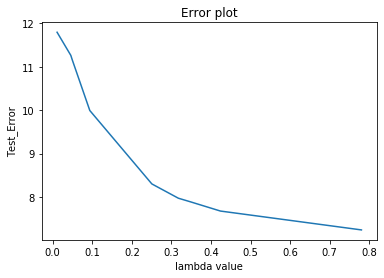

In [99]:
lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [100]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=91.964000%

precision=92.761921%

recall=98.363923%

F1-Score=95.480823%


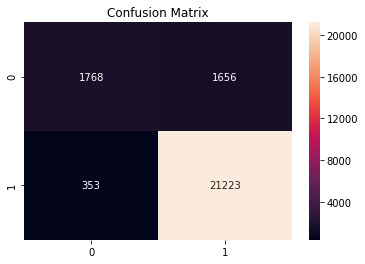

In [101]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [102]:
clf = LogisticRegression(C = optimal_a1 , penalty='l1')

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=92.220000%

precision=93.483365%

recall=97.803115%

F1-Score=95.594464%


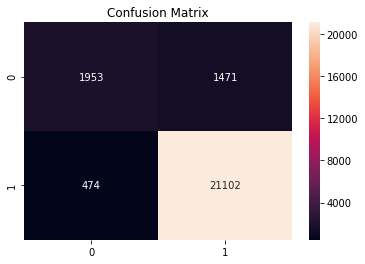

In [103]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [104]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Random'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+
|   CV   | Regularizer |         C          | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+
| Random |      L2     | 0.7801600324851742 |    91.96    |      8.04     |    92.76     |   98.36   |    95.48    |
| Random |      L1     | 0.7801600324851742 |    92.22    |      7.78     |    93.48     |    97.8   |    95.59    |
+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+


### Perturbation test on TF-IDF

In [105]:
pre_w = clf.coef_[0]

noise_data = tf_X_train.todense()
noise_data[1323] += 0.01

clf = LogisticRegression(C = optimal_a1 , penalty='l1')
clf.fit(noise_data,y_train)

new_w = clf.coef_[0]

per_Change = Weight_change(pre_w,new_w)

print(per_Change)

51.9


##### Even here we get change in weight vectors is high, so features are collinear.

In [106]:
clf = LogisticRegression(C=100, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=10, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac2 = accuracy_score(y_test, pred) * 100
er2 = np.around(100 - ac2, decimals = 2)

w = clf.coef_
s2 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=1, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac3 = accuracy_score(y_test, pred) * 100
er3 = np.around(100 - ac3, decimals = 2)

w = clf.coef_
s3 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac4 = accuracy_score(y_test, pred) * 100
er4 = np.around(100 - ac4, decimals = 2)

w = clf.coef_
s4 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac5 = accuracy_score(y_test, pred) * 100
er5 = np.around(100 - ac5, decimals = 2)

w = clf.coef_
s5 = np.count_nonzero(w)

#======================================================================

In [107]:

x = PrettyTable()

c = [100,10,1,0.1,0.01]

x.field_names = ['C','Train_Error(%)','Sparsity']

x.add_row([c[0],er1,s1])
x.add_row([c[1],er2,s2])
x.add_row([c[2],er3,s3])
x.add_row([c[3],er4,s4])
x.add_row([c[4],er5,s5])

print(x)

+------+----------------+----------+
|  C   | Train_Error(%) | Sparsity |
+------+----------------+----------+
| 100  |      7.76      |   1989   |
|  10  |      7.66      |   1883   |
|  1   |      7.7       |   1207   |
| 0.1  |     10.06      |   212    |
| 0.01 |      13.7      |    5     |
+------+----------------+----------+


### AVG Word2Vec

In [108]:
from gensim.models import Word2Vec

w2v_data = X_train

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_train = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    avg_X_train.append(vec/count)
    
#================================================================
w2v_data = X_test

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_test = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    if count==0:
        avg_X_test.append(vec)
    else:
        avg_X_test.append(vec/count)

#### GridSearchCV

In [109]:
lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression(class_weight ='balanced')
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(avg_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 1}
Accuracy on train data =  80.604


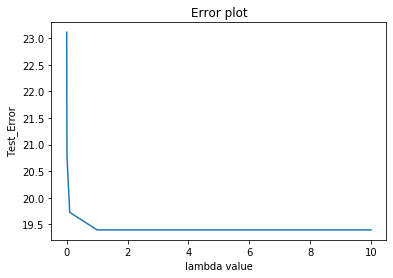

In [110]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()


#### Using L2 Reg

In [111]:
clf = LogisticRegression(C = optimal_a1,class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=85.708000%

precision=86.327132%

recall=99.142566%

F1-Score=92.292094%


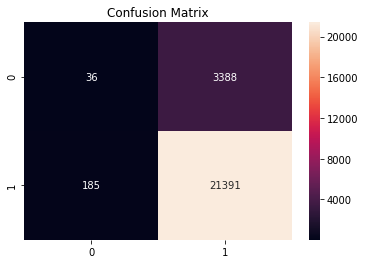

In [112]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

#### Using L1 Reg

In [113]:
clf = LogisticRegression(C = optimal_a1,penalty='l1',class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=85.704000%

precision=86.320717%

recall=99.147201%

F1-Score=92.290435%


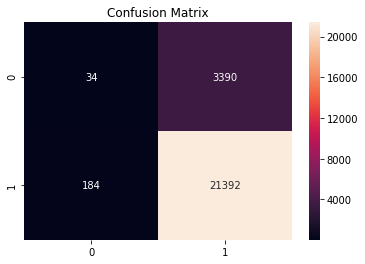

In [114]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [115]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 1 |    85.71    |     14.29     |    86.33     |   99.14   |    92.29    |
| Grid |      L1     | 1 |     85.7    |      14.3     |    86.32     |   99.15   |    92.29    |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+


#### RandomSearchCV

In [116]:
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(avg_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.5653998771368701}
Accuracy on train data =  90.244


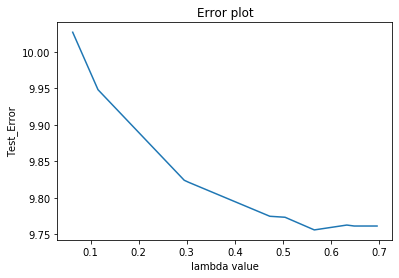

In [117]:
lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

#### Using L2

In [118]:

clf = LogisticRegression(C = optimal_a1,class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=85.716000%

precision=86.337033%

recall=99.137931%

F1-Score=92.295743%


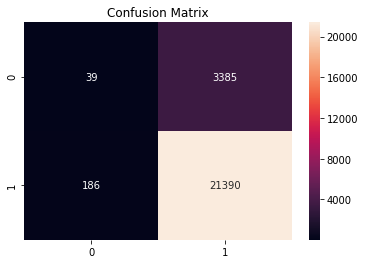

In [119]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

#### Using L1

In [120]:
clf = LogisticRegression(C = optimal_a1,penalty='l1',class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=85.696000%

precision=86.319613%

recall=99.137931%

F1-Score=92.285788%


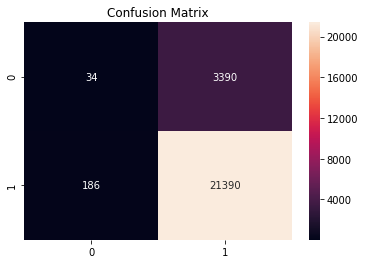

In [121]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [122]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Random'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+
|   CV   | Regularizer |         C          | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+
| Random |      L2     | 0.5653998771368701 |    85.72    |     14.28     |    86.34     |   99.14   |     92.3    |
| Random |      L1     | 0.5653998771368701 |     85.7    |      14.3     |    86.32     |   99.14   |    92.29    |
+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+


In [123]:
del avg_X_train
del avg_X_test

### TF-IDF Word2Vec

In [124]:
tf_w_data = X_train
tf_idf = TfidfVectorizer(max_features=2000)
tf_idf_data = tf_idf.fit_transform(tf_w_data)
tf_train_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    #print(vec)
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_train_data.append(vec)
    i = i + 1
    
    
    
#====================================================================================

tf_w_data = X_test
tf_idf_data = tf_idf.transform(tf_w_data)
tf_test_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_test_data.append(vec)
    i = i + 1

#### GridSearchCV

In [126]:
lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression(class_weight ='balanced')
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(tf_train_data, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 10}
Accuracy on train data =  73.17333333333333


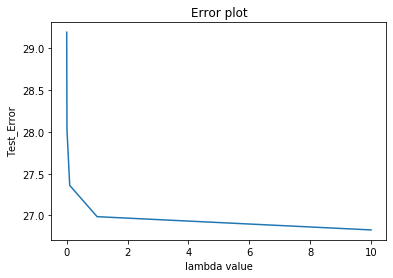

In [127]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

#### Using L2 Reg

In [128]:
clf = LogisticRegression(C = optimal_a1,class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=72.828000%

precision=95.316044%

recall=72.056915%

F1-Score=82.070367%


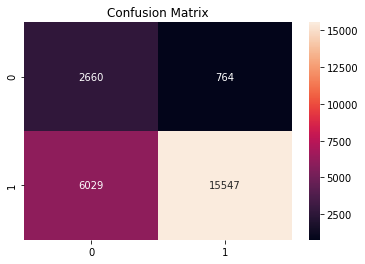

In [129]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

#### Using L1 Reg

In [131]:
clf = LogisticRegression(C = optimal_a1,penalty = 'l1',class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=72.828000%

precision=95.366108%

recall=72.015202%

F1-Score=82.061845%


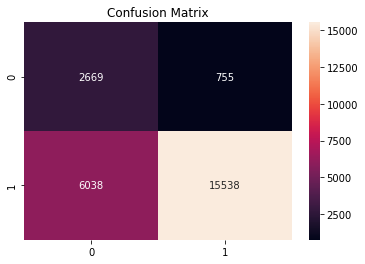

In [132]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [133]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 10 |    72.83    |     27.17     |    95.32     |   72.06   |    82.07    |
| Grid |      L1     | 10 |    72.83    |     27.17     |    95.37     |   72.02   |    82.06    |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+


#### RandomSearchCV

In [134]:
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(tf_train_data, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.8087895533763105}
Accuracy on train data =  88.42933333333333


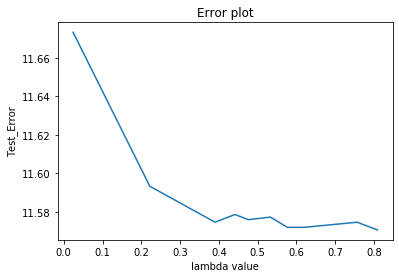

In [135]:

lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

#### Using L2 Reg

In [137]:
clf = LogisticRegression(C = optimal_a1,class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=72.532000%

precision=95.200049%

recall=71.792733%

F1-Score=81.855893%


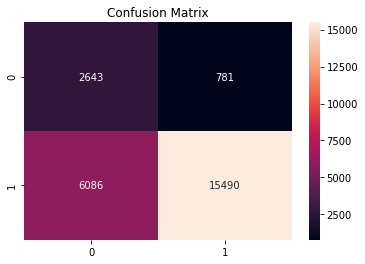

In [138]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

#### Using L1 Reg

In [139]:
clf = LogisticRegression(C = optimal_a1,penalty = 'l1',class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=72.644000%

precision=95.280526%

recall=71.862254%

F1-Score=81.930830%


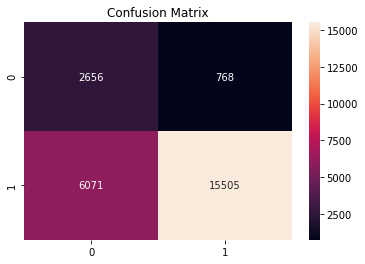

In [140]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [141]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Random'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+
|   CV   | Regularizer |         C          | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+
| Random |      L2     | 0.8087895533763105 |    72.53    |     27.47     |     95.2     |   71.79   |    81.86    |
| Random |      L1     | 0.8087895533763105 |    72.64    |     27.36     |    95.28     |   71.86   |    81.93    |
+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+


## Summary And Observations

### * Considered 100k datapoints for running this model
### * Used Pretty table to show all the data in a table format so that user can understand whats going on with every model.
### * Done Perturbation test and found out that features are collinear.
### * Both BoW and TF-IDF models gave best accuracies compared to AVG W2V and TF-IDF W2V
### * Also Proved that as C value decreases sparsity also decreases.
### * Plotted Error plots, Heat maps for confusion matrix, Pretty tables for all models.